# SIADS 696 Project - Part B: Unsupervised Learning Notebook

In [ ]:
import numpy as np
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import re
from scipy.stats import entropy
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from scipy.cluster.hierarchy import ward, fcluster, dendrogram
from scipy.spatial.distance import pdist
from sklearn.manifold import TSNE
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud


# Import and Process Text Data

In [ ]:
#Reading in text data 
textData_1 = pd.read_csv('https://raw.githubusercontent.com/nruloff/Difficulty_Classification_of_Textual_Passages/main/Data/WikiLarge_Train_part_1.csv')
textData_2 = pd.read_csv('https://raw.githubusercontent.com/nruloff/Difficulty_Classification_of_Textual_Passages/main/Data/WikiLarge_Train_part_2.csv')
textData_3 = pd.read_csv('https://raw.githubusercontent.com/nruloff/Difficulty_Classification_of_Textual_Passages/main/Data/WikiLarge_Train_part_3.csv')
text_data = pd.concat([textData_1, textData_2, textData_3], ignore_index=True)

In [ ]:
#Removing duplicate text documents
print(text_data.shape)
text_data = text_data.drop_duplicates(subset=['original_text'])
print(text_data.shape)

(416768, 2)
(347356, 2)


In [ ]:

# removing lrb and rrb from strings
text_data['original_text'] = text_data['original_text'].str.replace('LRB',' ')
text_data['original_text'] = text_data['original_text'].str.replace('RRB',' ')

In [ ]:
#Taking a smaple to save time
data_sample = text_data.sample(n=40000, replace=False, random_state=0)
print(data_sample.shape)
#checking label distribution
print(data_sample['label'].value_counts())

(40000, 2)
1    20137
0    19863
Name: label, dtype: int64


In [ ]:
#Splitting the data into a train df and test df
#This is for evaluation of dimensionality reduction effectiveness using a classifier

one = round(len(data_sample)*0.8)
train_df, test_df = np.split(data_sample, [one])

print(train_df.shape)

(32000, 2)


In [ ]:
#Turing the text data into a sparse matrix using a term frequency inverse document frequency vectorizer

vectorizer = TfidfVectorizer(ngram_range=(1, 2), token_pattern=r'\w+|\$[\d\.]+|\S+', max_features=20000)

X_train = vectorizer.fit_transform(train_df['original_text'])
y_train = train_df.label.to_list()
print(X_train.shape)

(32000, 20000)


In [ ]:
X_test = vectorizer.transform(test_df['original_text'])
print(X_test.shape)
y_test = test_df.label.to_list()
print(len(y_test))

(8000, 20000)
8000


# Feature Representation Evaluation

In [ ]:
vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=20000)

X_train = vectorizer.fit_transform(train_df['original_text'])
y_train = train_df.label.to_list()


In [ ]:
# Cross validation using the logistic regression classifier

clf = LogisticRegression(max_iter=1000) #had to increase max iter to get model to converge
scores = cross_val_score(clf, X_train, y_train, cv=5)
print(scores)
print("%0.3f accuracy with a standard deviation of %0.3f" % (scores.mean(), scores.std()))

[0.63828125 0.63859375 0.63609375 0.63828125 0.64546875]
0.639 accuracy with a standard deviation of 0.003


In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))

X_train = vectorizer.fit_transform(train_df['original_text'])
y_train = train_df.label.to_list()

In [ ]:
# Cross validation using the logistic regression classifier

clf = LogisticRegression()
scores = cross_val_score(clf, X_train, y_train, cv=5)
print(scores)
print("%0.3f accuracy with a standard deviation of %0.3f" % (scores.mean(), scores.std()))

[0.6478125  0.65609375 0.65046875 0.65203125 0.651875  ]
0.652 accuracy with a standard deviation of 0.003


In [ ]:

vectorizer = TfidfVectorizer(ngram_range=(1, 2), token_pattern=r'\w+|\$[\d\.]+|\S+')

X_train = vectorizer.fit_transform(train_df['original_text'])


In [ ]:
# Cross validation using the logistic regression classifier

clf = LogisticRegression()
scores = cross_val_score(clf, X_train, y_train, cv=5)
print(scores)
print("%0.3f accuracy with a standard deviation of %0.3f" % (scores.mean(), scores.std()))

[0.669375   0.6615625  0.6684375  0.66140625 0.66875   ]
0.666 accuracy with a standard deviation of 0.004


In [ ]:

vectorizer = TfidfVectorizer(ngram_range=(1, 2), token_pattern=r'\w+|\$[\d\.]+|\S+', max_features=50000)

X_train = vectorizer.fit_transform(train_df['original_text'])


In [ ]:
# Cross validation using the logistic regression classifier

clf = LogisticRegression()
scores = cross_val_score(clf, X_train, y_train, cv=5)
print(scores)
print("%0.3f accuracy with a standard deviation of %0.3f" % (scores.mean(), scores.std()))

[0.67640625 0.66796875 0.670625   0.66734375 0.66984375]
0.670 accuracy with a standard deviation of 0.003


In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), token_pattern=r'\w+|\$[\d\.]+|\S+', max_features=20000)

X_train = vectorizer.fit_transform(train_df['original_text'])

In [ ]:
# Cross validation using the logistic regression classifier

clf = LogisticRegression()
scores = cross_val_score(clf, X_train, y_train, cv=5)
print(scores)
print("%0.3f accuracy with a standard deviation of %0.3f" % (scores.mean(), scores.std()))

[0.67875    0.67140625 0.67484375 0.6678125  0.6746875 ]
0.673 accuracy with a standard deviation of 0.004


# Dimensionality Reduction

PCA

In [ ]:
# Trying PCA Just to See 
# Using a large number of components and features in this cell will crash the notebook
# needed to run this locally

X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()
pca = PCA(n_components=10)
pca.fit(X_train_dense)
X_train_pca = pca.transform(X_train_dense)
X_test_pca = pca.transform(X_test_dense)


In [ ]:
print(X_train_pca.shape)
print(pca.explained_variance_ratio_[0:10])
print(pca.explained_variance_ratio_.sum())

In [ ]:
# plotting the first 2 PCA components
print(pca.components_.shape)
fig, ax = plt.subplots()
ax.scatter(X_train_pca[:,0], X_train_pca[:,1], c = y_train)
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')

plt.show()

SVD

In [ ]:

# no scaling necessary because units of all features are the same (don't want to reduce strong signals)

svd = TruncatedSVD(n_components=500, n_iter=7)
svd.fit(X_train)
X_train_svd = svd.transform(X_train)
X_test_svd = svd.transform(X_test)

print(X_train_svd.shape)

(32000, 500)


In [ ]:
# Looking at varrience explained by component and total varrience explained

#print(svd.explained_variance_ratio_[0:10])
#print(svd.explained_variance_ratio_.sum())
#sorted_arr = np.sort(svd.explained_variance_ratio_)
#print(sorted_arr[-10:])
print(svd.explained_variance_ratio_[0:50].sum())

0.12324424985474935


In [ ]:
# plotting varience explained vs components kept
components = [10, 50, 100, 200, 300, 400, 500, 750, 1000, 1500, 2000, 2500]
var_list = []
for comp in components:
  var = svd.explained_variance_ratio_[0:comp].sum()
  var_list.append(var)

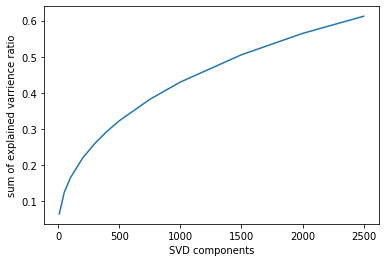

In [ ]:
fig, axs = plt.subplots()

axs.plot(components, var_list)
#axs.set_title('')
axs.set_xlabel('SVD components')  
axs.set_ylabel('sum of explained varrience ratio') 

plt.show()

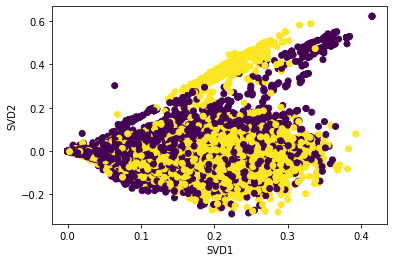

In [ ]:
# plotting the first 2 SVD components
fig, ax = plt.subplots()
ax.scatter(X_train_svd[:,0], X_train_svd[:,1], c = y_train)
ax.set_xlabel('SVD1')
ax.set_ylabel('SVD2')

plt.show()

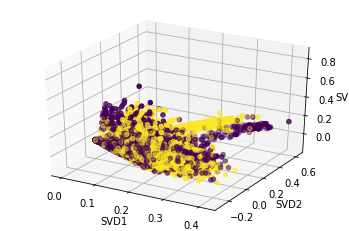

In [ ]:
fig = plt.figure()

ax = fig.add_subplot(projection='3d')

ax.scatter(X_train_svd[:,0], X_train_svd[:,1], X_train_svd[:,2],  c = y_train)
ax.set_xlabel('SVD1')
ax.set_ylabel('SVD2')
ax.set_zlabel('SVD3')
plt.show()

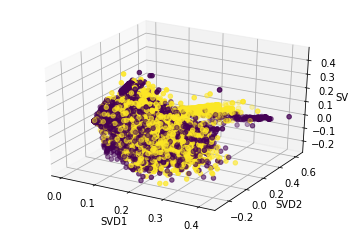

In [ ]:
fig = plt.figure()

ax = fig.add_subplot(projection='3d')

ax.scatter(X_train_svd[:,0], X_train_svd[:,1], X_train_svd[:,3],  c = y_train)
ax.set_xlabel('SVD1')
ax.set_ylabel('SVD2')
ax.set_zlabel('SVD3')
plt.show()

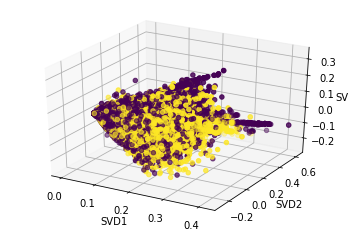

In [ ]:
fig = plt.figure()

ax = fig.add_subplot(projection='3d')

ax.scatter(X_train_svd[:,0], X_train_svd[:,1], X_train_svd[:,4],  c = y_train)
ax.set_xlabel('SVD1')
ax.set_ylabel('SVD2')
ax.set_zlabel('SVD3')
plt.show()

In [ ]:
# This cell computes accuracy over a range of components for logistic regression, SVM, and Random Forest models
components = [5, 10, 25, 50, 100, 200, 300]
lr_acc_score_l = []
svm_acc_score_l = []
rf_acc_score_l = []

for comp in tqdm(components):
    clf = LogisticRegression(random_state=0)
    clf.fit(X_train_svd[:, 0:comp], y_train)
    lr_acc_score = clf.score(X_test_svd[:, 0:comp], y_test)
    lr_acc_score_l.append(lr_acc_score)

    svm_clf = SVC(kernel='rbf', random_state=0) 
    svm_clf = svm_clf.fit(X_train_svd[:, 0:comp], y_train)
    svm_acc_score = svm_clf.score(X_test_svd[:, 0:comp], y_test)
    svm_acc_score_l.append(svm_acc_score)

    rf_clf = RandomForestClassifier( max_depth=32, random_state=0) 
    rf_clf = rf_clf.fit(X_train_svd[:, 0:comp], y_train)
    rf_acc_score = rf_clf.score(X_test_svd[:, 0:comp], y_test)
    rf_acc_score_l.append(rf_acc_score)

100%|██████████| 7/7 [31:51<00:00, 273.03s/it]


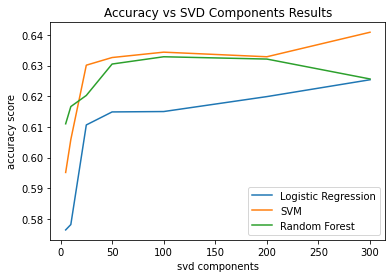

In [ ]:
fig, axs = plt.subplots()
#fig.set_size_inches(15, 15)

axs.plot(components, lr_acc_score_l, label='Logistic Regression')
axs.plot(components, svm_acc_score_l, label='SVM')
axs.plot(components, rf_acc_score_l, label='Random Forest')

axs.set_title('Accuracy vs SVD Components Results')
axs.set_xlabel('svd components')  
axs.set_ylabel('accuracy score') 
axs.legend()

In [ ]:
# Looking for accuracy plateau as SVD components increase
# Here I increased the range of components and only used a logisttic regression classifier

components = [5, 10, 25, 50, 100, 200, 300, 400, 500, 600, 700]
lr_acc_score_l = []
#svm_acc_score_l = []
#rf_acc_score_l = []

for comp in tqdm(components):
    clf = LogisticRegression(random_state=0)
    clf.fit(X_train_svd[:, 0:comp], y_train)
    lr_acc_score = clf.score(X_test_svd[:, 0:comp], y_test)
    lr_acc_score_l.append(lr_acc_score)

    #svm_clf = SVC(kernel='rbf', random_state=0) 
    #svm_clf = svm_clf.fit(X_train_svd[:, 0:comp], y_train)
    #svm_acc_score = svm_clf.score(X_test_svd[:, 0:comp], y_test)
    #svm_acc_score_l.append(svm_acc_score)

100%|██████████| 11/11 [00:10<00:00,  1.08it/s]


[0.572875, 0.591, 0.616125, 0.634375, 0.639875, 0.651625, 0.661125, 0.658625, 0.66075, 0.66375, 0.660375]


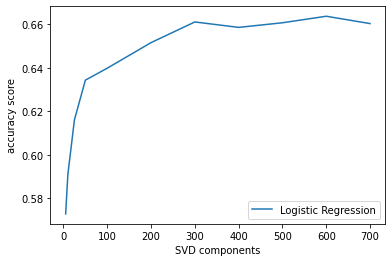

In [ ]:
print(lr_acc_score_l)
#print(svm_acc_score_l)

fig, axs = plt.subplots()
#fig.set_size_inches(15, 15)

axs.plot(components, lr_acc_score_l, label='Logistic Regression')
#axs.plot(components, svm_acc_score_l, label='SVM')


#axs.set_title('Accuracy vs SVD Components Results')
axs.set_xlabel('SVD components')  
axs.set_ylabel('accuracy score') 
axs.legend()

plt.show()

In [ ]:
clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.676375


Comparing PCA, SVD, and Origional accuracy using cross val logistic regression

In [ ]:
# Cross validation of accuracy using PCA components using the logistic regression classifier

clf = LogisticRegression()
scores = cross_val_score(clf, X_train_pca[:,0:10], y_train, cv=5)
print(scores)
print("%0.3f accuracy with a standard deviation of %0.3f" % (scores.mean(), scores.std()))

In [ ]:
# Cross validation of accuracy using SVD components using the logistic regression classifier

clf = LogisticRegression()
scores = cross_val_score(clf, X_train_svd[:,0:500], y_train, cv=5)
print(scores)
print("%0.3f accuracy with a standard deviation of %0.3f" % (scores.mean(), scores.std()))

[0.66203125 0.6609375  0.655625   0.65359375 0.65796875]
0.658 accuracy with a standard deviation of 0.003


In [ ]:
# Cross validation of accuracy using all data using the logistic regression classifier

clf = LogisticRegression()
scores = cross_val_score(clf, X_train, y_train, cv=5)
print(scores)
print("%0.3f accuracy with a standard deviation of %0.3f" % (scores.mean(), scores.std()))

In [ ]:
# Cross validation of accuracy using all features using dummy classifier

dummy_clf_uni = DummyClassifier(strategy="uniform") #unifor because class labels are approx even
scores = cross_val_score(dummy_clf_uni, X_train, y_train, cv=5)
print(scores)
print("%0.3f accuracy with a standard deviation of %0.3f" % (scores.mean(), scores.std()))

[0.5025    0.4953125 0.5075    0.4965625 0.4946875]
0.499 accuracy with a standard deviation of 0.005


MDS

In [ ]:
X_train_dense = X_train.toarray()
embedding = MDS()
X_train_mds = embedding.fit_transform(X_train_dense)
X_train_mds.shape

In [ ]:
# plotting the MDS components

fig, ax = plt.subplots()
ax.scatter(X_train_mds[:,0], X_train_mds[:,1], c = y_train)
ax.set_xlabel('MDS1')
ax.set_ylabel('MDS2')

plt.show()

NNMF

In [ ]:
from sklearn.decomposition import NMF

model = NMF(n_components=700, init='random', random_state=0)
X_train_nnmf = model.fit_transform(X_train)
X_train_nnmf.shape
X_test_nnmf = model.transform(X_test)

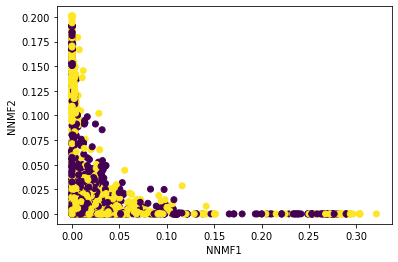

In [ ]:
# plotting the NNMF components

fig, ax = plt.subplots()
ax.scatter(X_train_nnmf[:,0], X_train_nnmf[:,1], c = y_train)
ax.set_xlabel('NNMF1')
ax.set_ylabel('NNMF2')

plt.show()

In [ ]:
# Cross validation of accuracy using NNMF components using the logistic regression classifier

clf = LogisticRegression()
scores = cross_val_score(clf, X_train_nnmf[:,0:10], y_train, cv=5)
print(scores)
print("%0.3f accuracy with a standard deviation of %0.3f" % (scores.mean(), scores.std()))

[0.59078125 0.58546875 0.59265625 0.573125   0.601875  ]
0.589 accuracy with a standard deviation of 0.009


In [ ]:
# Looking for accuracy plateau as components increase
# Here I increased the range of components and only used a logisttic regression classifier

components = [5, 10, 25, 50, 100, 200, 300, 400, 500, 600, 700]
lr_acc_score_l = []
#svm_acc_score_l = []
#rf_acc_score_l = []

for comp in tqdm(components):
    clf = LogisticRegression(random_state=0)
    clf.fit(X_train_nnmf[:, 0:comp], y_train)
    lr_acc_score = clf.score(X_test_nnmf[:, 0:comp], y_test)
    lr_acc_score_l.append(lr_acc_score)

    

In [ ]:

fig, axs = plt.subplots()

axs.plot(components, lr_acc_score_l, label='Logistic Regression')
#axs.set_title('')
axs.set_xlabel('NMF components')  
axs.set_ylabel('accuracy score') 

plt.show()

# Clustering

In [ ]:
# Creating one document term matrix for the whole data sample

#vectorizer = TfidfVectorizer(ngram_range=(1, 2))
vectorizer = TfidfVectorizer(ngram_range=(1, 2), token_pattern=r'\w+|\$[\d\.]+|\S+', max_features=20000)


X = vectorizer.fit_transform(data_sample['original_text'])
y = data_sample['label']

In [ ]:
# Creating new features with reduced dimensions using svd

svd = TruncatedSVD(n_components=500, n_iter=7)
svd.fit(X)
X_svd = svd.transform(X)


In [ ]:
# finding optimal k using inertia method. This is largely derived from SIADS 680 Assignment 2

inertia = []
for n in range(1 , 7):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='full') )
    algorithm.fit(X)
    inertia.append(algorithm.inertia_)

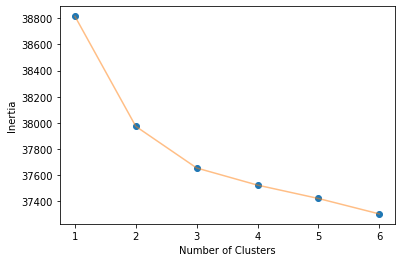

In [ ]:
#Plot the interia points to create the elbow plot

#plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 7) , inertia , 'o')
plt.plot(np.arange(1 , 7) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

In [ ]:
# Finding optimal k value
#The followign technique to determine optimal number of clusters is drawn from the University of Michigan SIADS 543 Assignment 2: Clustering notebook.

def optimal_k_kmeans(k_list, X):
  score_list = []

  for k in k_list:
    kmeans = KMeans(n_clusters = k, init='k-means++', max_iter=100, n_init=1)
    kmeans.fit(X)
    labels = kmeans.labels_
    ch_score = metrics.calinski_harabasz_score(X, labels)
    db_score = metrics.davies_bouldin_score(X, labels)
    s_score = metrics.silhouette_score(X, labels, metric='euclidean')
    score_list.append((k, ch_score, db_score, s_score))
  return score_list

#--------------------------------------------------------------------------------
#from scipy.cluster.hierarchy import ward, fcluster, dendrogram
#from scipy.spatial.distance import pdist

def optimal_k_ward(k_list, X):
  score_list = []
  for k in k_list:
      h_cls = ward(X)
      flat_cls = fcluster(h_cls, t=k, criterion='maxclust')
      labels = flat_cls
      ch_score = metrics.calinski_harabasz_score(X, labels)
      db_score = metrics.davies_bouldin_score(X, labels)
      s_score = metrics.silhouette_score(X, labels, metric='euclidean')
      score_list.append((k, ch_score, db_score, s_score))
  return score_list

In [ ]:
# this cell performs 3 runs of the optimal k means function and creates a lit ot get average
X_dense = X.toarray()
print(X_dense.shape)
k_list = [2, 3, 4, 5]

s_list = []
res_list = []
for i in range(3):
  s_list = optimal_k_kmeans(k_list, X_svd[0:10000,0:50])
  res_list.append(s_list)
res_list = np.array(res_list)
#print(res_list)

(40000, 20000)


In [ ]:
# getting mean of quality scores for each k value
k2 = np.mean(np.concatenate((res_list[0:1,0:1,1:], res_list[1:2,0:1,1:], res_list[2:,0:1,1:]), axis=0), axis=0)
k3 = np.mean(np.concatenate((res_list[0:1,1:2,1:], res_list[1:2,1:2,1:], res_list[2:,1:2,1:]), axis=0), axis=0)
k4 = np.mean(np.concatenate((res_list[0:1,2:3,1:], res_list[1:2,2:3,1:], res_list[2:,2:3,1:]), axis=0), axis=0)
k5 = np.mean(np.concatenate((res_list[0:1,3:,1:], res_list[1:2,3:,1:], res_list[2:,3:,1:]), axis=0), axis=0)
np.set_printoptions(suppress=True)
print(k2.round(decimals=3))
print(k3.round(decimals=3))
print(k4.round(decimals=3))
print(k5.round(decimals=3))

[[1627.144    1.595    0.32 ]]
[[1445.258    1.491    0.252]]
[[1200.167    2.448    0.168]]
[[987.526   2.356   0.143]]


In [ ]:
s_list = []
res_list = []
for i in range(3):
  s_list = optimal_k_ward(k_list, X_svd[0:10000,0:50])
  res_list.append(s_list)
res_list = np.array(res_list)

In [ ]:
k2 = np.mean(np.concatenate((res_list[0:1,0:1,1:], res_list[1:2,0:1,1:], res_list[2:,0:1,1:]), axis=0), axis=0)
k3 = np.mean(np.concatenate((res_list[0:1,1:2,1:], res_list[1:2,1:2,1:], res_list[2:,1:2,1:]), axis=0), axis=0)
k4 = np.mean(np.concatenate((res_list[0:1,2:3,1:], res_list[1:2,2:3,1:], res_list[2:,2:3,1:]), axis=0), axis=0)
k5 = np.mean(np.concatenate((res_list[0:1,3:,1:], res_list[1:2,3:,1:], res_list[2:,3:,1:]), axis=0), axis=0)
np.set_printoptions(suppress=True)
print(k2.round(decimals=3))
print(k3.round(decimals=3))
print(k4.round(decimals=3))
print(k5.round(decimals=3))

[[1900.976    1.686    0.23 ]]
[[1507.663    1.603    0.25 ]]
[[1154.158    1.49     0.257]]
[[977.529   1.64    0.164]]


Visualizing Cluster Lables

In [ ]:
def kmeans_cluster(k, X):
  kmeans = KMeans(n_clusters = k, init='k-means++', max_iter=100, n_init=1)
  kmeans.fit(X)
  labels = kmeans.labels_
  return labels

In [ ]:
labels = kmeans_cluster(2, X_svd)

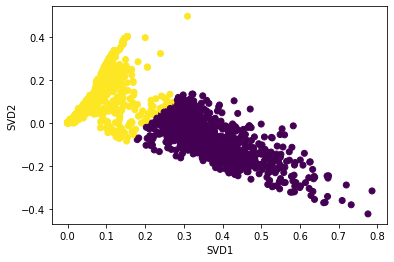

In [ ]:
# plotting the first 2 SVD components with colors as k-means labels
fig, ax = plt.subplots()
ax.scatter(X_svd[0:5000,0], X_svd[0:5000,1], c = labels[0:5000])
ax.set_xlabel('SVD1')
ax.set_ylabel('SVD2')

plt.show()

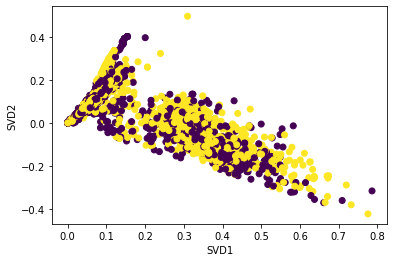

In [ ]:
# plotting the first 2 SVD components with colors as difficult label
fig, ax = plt.subplots()
ax.scatter(X_svd[0:5000,0], X_svd[0:5000,1], c = y[0:5000])
ax.set_xlabel('SVD1')
ax.set_ylabel('SVD2')

plt.show()

In [ ]:
X_dense = X.toarray()
pca = PCA(n_components=2)
pca.fit(X_dense)
X_pca = pca.transform(X_dense)

In [ ]:
# plotting the first 2 PCA components
print(pca.components_.shape)
fig, ax = plt.subplots()
ax.scatter(X_pca[:,0], X_pca[:,1], c = labels)
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')

Using only easy or diff labels

In [ ]:
#Creating individual dataframes for text labeled difficult and not difficult

diff_only = data_sample[data_sample['label'] == 1]
X_diff = diff_only['original_text']

easy_only = data_sample[data_sample['label'] == 0]
X_easy = easy_only['original_text']

In [ ]:
#vectorizer = TfidfVectorizer(ngram_range=(1, 2))
vectorizer = TfidfVectorizer(ngram_range=(1, 1), token_pattern=r'\w+|\$[\d\.]+|\S+', max_features=50000)

X_diff = vectorizer.fit_transform(X_diff)
X_easy = vectorizer.fit_transform(X_easy)

print(X_diff.shape)

(20137, 20000)


In [ ]:
terms = vectorizer.get_feature_names_out()

In [ ]:
# could try finding optimal k with only easy or diff

Hierarchical clustering

In [ ]:
# using scipy ward

#h_cls = ward(X.toarray())
h_cls = ward(X_svd[0:5000,0:10])
#print(h_cls)
flat_cls = fcluster(h_cls, t=2, criterion='maxclust')
#print(flat_cls.shape)


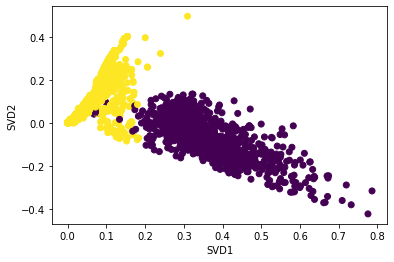

In [ ]:
# plotting the first 2 SVD components with ward clusters as color
fig, ax = plt.subplots()
ax.scatter(X_svd[0:5000,0], X_svd[0:5000,1], c = flat_cls)
ax.set_xlabel('SVD1')
ax.set_ylabel('SVD2')

plt.show()

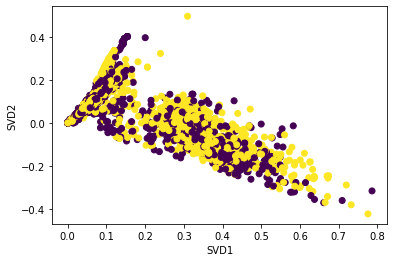

In [ ]:
# plotting the first 2 SVD components with text diff as color
fig, ax = plt.subplots()
ax.scatter(X_svd[0:5000,0], X_svd[0:5000,1], c = y[0:5000])
ax.set_xlabel('SVD1')
ax.set_ylabel('SVD2')

plt.show()

# t-SNE

In [ ]:

X_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30).fit_transform(X_svd[0:5000,0:50])
X_tsne.shape

(5000, 2)

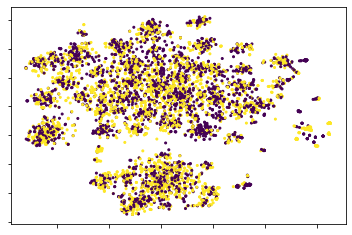

In [ ]:
# plotting the first TSNE components with text difficulty as color
fig, ax = plt.subplots()
ax.scatter(X_tsne[:,0], X_tsne[:,1], c = y[0:5000], s=4)
#ax.set_xlabel()
#ax.set_ylabel()
ax.set_yticklabels([])
ax.set_xticklabels([])

plt.show()

# Cluster Exploration

In [ ]:
#The followign cluster evaluation technique is drawn from the University of Michigan SIADS 543 Assignment 2: Clustering notebook.
# This function finds the average terms associated with each cluster

def avg_kmeans_terms(X):
    result = None

    # YOUR CODE HERE
    kmeans = KMeans(n_clusters = 2, init='k-means++', max_iter=100, n_init=1, random_state=0)
    kmeans.fit(X)
    centers = kmeans.cluster_centers_
    centers_sort = np.argsort(centers)
    centers_sort_1 = np.flip(centers_sort[0,:])
    top_c1 = centers_sort_1[0:10]
    c1_list = []
    
    centers_sort_2 = np.flip(centers_sort[1,:])
    top_c2 = centers_sort_2[0:10]
    c2_list = []
    
    terms = vectorizer.get_feature_names_out()
    
    for i in top_c1:
        x = terms[i]
        c1_list.append(x)  
    
    for i in top_c2:
        x = terms[i]
        c2_list.append(x)   
    
    #result = [c1_list, c2_list]
    result = [dict(zip(c1_list,top_c1)), dict(zip(c2_list, top_c2))]
    return result

In [ ]:
#vectorizer = TfidfVectorizer(ngram_range=(1, 2), token_pattern=r'\w+|\$[\d\.]+|\S+',stop_words='english', max_features=20000)
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=20000, stop_words='english')

X = vectorizer.fit_transform(data_sample['original_text'])
terms = vectorizer.get_feature_names_out()

In [ ]:
res = avg_kmeans_terms(X)
print(res[0])
print(res[1])

{'city': 4217, 'commune': 4621, 'united': 18800, 'france': 7777, 'states': 17322, 'known': 10375, 'used': 18904, 'united states': 18808, 'born': 3074, 'department': 5719}
{'football': 7642, 'football player': 7659, 'player': 14049, 'born': 3074, 'japanese football': 9844, 'japanese': 9841, 'football club': 7645, 'plays': 14069, 'club': 4376, 'national football': 12455}


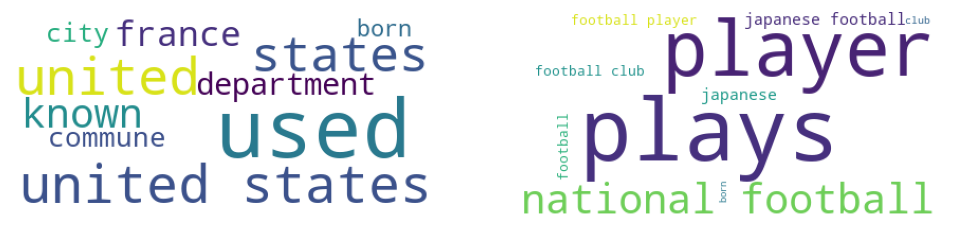

In [ ]:
fig = plt.figure(figsize=(10, 10), dpi=120)
for i in range(2):
    ax = fig.add_subplot(1,2,i+1)
    wordcloud = WordCloud(background_color="white").generate_from_frequencies(res[i])

    ax.imshow(wordcloud)
    ax.axis('off')

In [ ]:
#The followign cluster evaluation technique is drawn from the University of Michigan SIADS 543 Assignment 2: Clustering notebook.
#The functons compute_distinctive_term_score(T, T_a) and one_vs_all_count_matrix(m, index) were copied directly from the assigment

def compute_distinctive_term_score(T, T_a):
    # First compute information gain
    IG = entropy(T) - entropy(T_a)
    # if it's high IG, but not for this class, we want to penalize
    if T_a[0] < T_a[1]:
        score = -IG
    else:
        score = IG
    return score


# create a 1-vs-all two-class matrix for each cluster
def one_vs_all_count_matrix(m, index):
    # row zero is the selected row
    row0 = m[index, :]
    # row one is the other rows summed
    row1 = np.vstack((m[0:index, :], m[index + 1 :, :])).sum(axis=0)

    result = np.vstack((row0, row1))
    return result

In [ ]:
#The followign cluster evaluation technique is drawn from the University of Michigan SIADS 543 Assignment 2: Clustering notebook.
# This function returns distinctive terms from each cluster

def uniq_cluster_labeling(X):
    result = None

    # YOUR CODE HERE
    kmeans = KMeans(n_clusters = 2, init='k-means++', max_iter=100, n_init=1, random_state=0)
    kmeans.fit(X)
    centers = kmeans.cluster_centers_
    
    score_list = []
    cluster_list = []
    
    for cluster in range(centers.shape[0]):
        all_c = one_vs_all_count_matrix(centers, cluster)
        t_c1 = np.sum(all_c, axis=1)
        t_c2 = np.sum(t_c1)
        t_c = t_c1/t_c2  
        
        for col in range(all_c.shape[1]):
            t_w1 = all_c[:,col]
            t_w2 = np.sum(t_w1)
            t_w = t_w1/t_w2
            score = compute_distinctive_term_score(t_c, t_w)  
            score_list.append(score)  
                         
        word_in = np.array(score_list)
        score_list = []
        word_in_sort = np.argsort(word_in)
        word_flip = np.flip(word_in_sort)
        word_index = word_flip[0:10]
        temp_list = []
        
        for i in word_index:
            x = terms[i]
            temp_list.append(x)
            
        cluster_list.append(temp_list)
    result = cluster_list
    return result

In [ ]:
#uniq_cluster_labeling(X_diff)
uniq_cluster_labeling(X)

[['- highest',
  'uk -',
  '- officially',
  'produced world',
  'hockey goaltender',
  '- née',
  'history -',
  'ufficiale',
  '- nã',
  'hiroshi'],
 ['airport ,',
  '. later',
  'nwa',
  'distance .',
  ', heavy',
  'distant',
  'nã es',
  'distribute',
  ', help',
  'song american']]

SVD and Visulization using cluster labels

In [ ]:
k = 4

kmeans = KMeans(n_clusters = k, init='k-means++', max_iter=100, n_init=1, random_state=0)
kmeans.fit(X)
labels = kmeans.labels_

In [ ]:
svd = TruncatedSVD(n_components=10, n_iter=7, random_state=42)
#svd.fit(X_diff)
#X_svd = svd.transform(X_diff)
svd.fit(X)
X_svd = svd.transform(X)

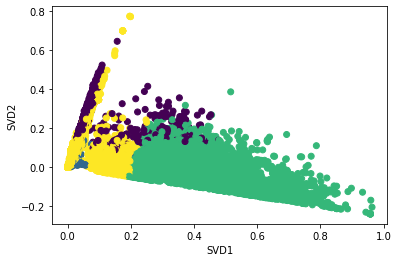

In [ ]:
# plotting the first 2 SVD components with color as k-means cluster label
fig, ax = plt.subplots()
ax.scatter(X_svd[:,0], X_svd[:,1], c = labels)
ax.set_xlabel('SVD1')
ax.set_ylabel('SVD2')

plt.show()

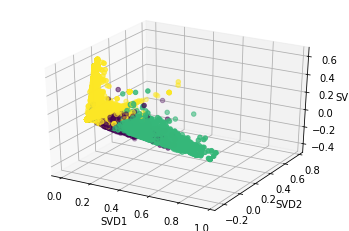

In [ ]:
fig = plt.figure()

ax = fig.add_subplot(projection='3d')

ax.scatter(X_svd[:,0], X_svd[:,1], X_svd[:,2],  c = labels)
ax.set_xlabel('SVD1')
ax.set_ylabel('SVD2')
ax.set_zlabel('SVD3')
plt.show()

Exploring structural features of text in each cluster

In [ ]:
#print(diff_only.head())
diff_only['kmeans_label'] = labels
#print(diff_only.head())

In [ ]:
#Making dataframes fro each cluster and looking at numbers in each
diff_kmeans_1 = diff_only[diff_only['kmeans_label'] == 1]
print(diff_kmeans_1.shape)

diff_kmeans_0 = diff_only[diff_only['kmeans_label'] == 0]
print(diff_kmeans_0.shape)

diff_kmeans_2 = diff_only[diff_only['kmeans_label'] == 2]
print(diff_kmeans_2.shape)

diff_kmeans_3 = diff_only[diff_only['kmeans_label'] == 3]
print(diff_kmeans_3.shape)

(9585, 3)
(1537, 3)
(3510, 3)
(5505, 3)


In [ ]:
#diff_kmeans_1.original_text[0:10].tolist()

In [ ]:
#diff_kmeans_0.original_text[0:10].tolist()

In [ ]:
import nltk

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Using features like number of tokens, average token length, max token length, and non-alphanumeric charicters
# to look for differences between clusters

def get_avg_features(list_of_docs):
    num_toks_l = []
    avg_tok_len_l = []
    max_tok_len_l = []
    non_alpha_char_l =[] 
    numbers_norm_l = [] 
    
    for doc in list_of_docs:
        doc = doc.lower()
        #-------------------
        chars = re.findall('\W', doc)
        non_alpha = len(chars)/len(doc)
        non_alpha_char_l.append(non_alpha)
        #-------------------------------
        num_chars = re.findall('\d', doc)
        numbers_norm = len(num_chars)/len(doc)
        numbers_norm_l.append(numbers_norm)
        #------------------------------
        toks = nltk.word_tokenize(doc)
        num_toks = len(toks)
        num_toks_l.append(num_toks)
        #------------------------------
        temp_list = []
        for tok in toks:
            temp_list.append(len(tok))
            
        avg_tok = sum(temp_list)/len(temp_list)
        avg_tok_len_l.append(avg_tok)
        max_t = max(temp_list)
        max_tok_len_l.append(max_t)
        #------------------------------
    
    new_features = np.vstack(( np.asarray(num_toks_l),  np.asarray(avg_tok_len_l), np.asarray(max_tok_len_l), 
                   np.asarray(numbers_norm_l), np.asarray(non_alpha_char_l) )).T
    res = np.round(np.mean(new_features, axis=0), 2)
    return res

In [ ]:
# output order = number of tokens, average token length, max token length, ratio of numbers to all char, and ratio of non-alphanumeric charicters
get_avg_features(diff_kmeans_0.original_text)

array([3.261e+01, 4.210e+00, 1.088e+01, 2.000e-02, 2.600e-01])

In [ ]:
get_avg_features(diff_kmeans_1.original_text)

array([2.019e+01, 4.660e+00, 1.091e+01, 2.000e-02, 1.900e-01])

In [ ]:
get_avg_features(diff_kmeans_2.original_text)

array([29.3 ,  4.57, 11.08,  0.03,  0.24])

# Topic Modeling

In [ ]:
#The folowing code was derived from week three of SIADS 543

In [ ]:
tf_vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 2))
#tf_vectorizer = CountVectorizer(stop_words='english')
tf_documents = tf_vectorizer.fit_transform(data_sample['original_text'])
tf_feature_names = tf_vectorizer.get_feature_names_out()
print(tf_documents.shape)

(40000, 363621)


In [ ]:
n_topics = 5

lda = LatentDirichletAllocation(n_components = n_topics, random_state=0)
lda.fit(tf_documents)
topic_models = lda.components_

In [ ]:
num_top_words = 10

def display_topics(model, feature_names, no_top_words):
  top_words = []
  for topic_idx, topic in enumerate(model.components_):
        term_list = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        print("topic %d:" % (topic_idx), term_list)

display_topics(lda, tf_feature_names, num_top_words)

topic 0: ['france', 'commune', 'calais', 'pas', 'pas calais', 'department', 'north', 'region', 'united', 'known']
topic 1: ['known', 'called', 'born', 'used', 'american', 'second', 'people', 'city', 'new', 'january']
topic 2: ['born', 'city', 'football', 'united', 'states', 'united states', 'player', 'football player', 'known', 'county']
topic 3: ['united', 'tropical', 'new', 'time', 'states', 'called', 'known', 'city', 'united states', 'used']
topic 4: ['commune', 'france', 'department', 'region', 'football', 'new', 'national', 'united', 'world', 'south']


In [ ]:
print(lda.components_[0].shape)
print(lda.components_.shape)

(363621,)
(5, 363621)


In [ ]:
def get_topics(model, feature_names, no_top_words):
  top_words = []
  for topic_idx, topic in enumerate(model.components_):
        term_list = [(feature_names[i], topic[i]) for i in topic.argsort()[:-no_top_words - 1:-1]]
        term_list = dict(term_list)
        top_words.append(term_list)
  return top_words

In [ ]:
top_words = get_topics(lda, tf_feature_names, num_top_words)
#top_words

In [ ]:

wordcloud = WordCloud().generate_from_frequencies(top_words[0])
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [ ]:
for t in range(len(top_words)):
    wordcloud = WordCloud().generate_from_frequencies(top_words[t])
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

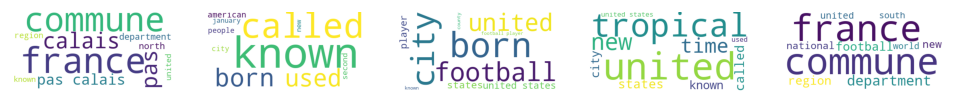

In [ ]:
fig = plt.figure(figsize=(10, 10), dpi=120)
for i in range(len(top_words)):
    ax = fig.add_subplot(1,5,i+1)
    wordcloud = WordCloud(background_color="white").generate_from_frequencies(top_words[i])

    ax.imshow(wordcloud)
    ax.axis('off')

In [ ]:
#Creating individual dataframes for text labeled difficult and not difficult

diff_only = data_sample[data_sample['label'] == 1]
X_diff = diff_only['original_text']
print(X_diff.shape)

easy_only = data_sample[data_sample['label'] == 0]
X_easy = easy_only['original_text']
print(X_easy.shape)

(20137,)
(19863,)


Difficult topics

In [ ]:
#tf_vectorizer = CountVectorizer(stop_words='english',token_pattern=r'\w+|\$[\d\.]+|\S+')
#tf_vectorizer = CountVectorizer(stop_words='english')
tf_vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 2))
tf_diff = tf_vectorizer.fit_transform(X_diff)
tf_feature_names = tf_vectorizer.get_feature_names_out()
print(tf_diff.shape)

(20137, 235634)


In [ ]:
n_topics = 5

lda = LatentDirichletAllocation(n_components = n_topics, random_state=0)
lda.fit(tf_diff)
topic_models = lda.components_

In [ ]:
display_topics(lda, tf_feature_names, num_top_words)

topic 0: ['known', 'world', 'year', 'new', 'city', 'located', 'born', 'area', 'american', 'united']
topic 1: ['born', 'time', 'known', 'american', 'city', 'football', 'national', 'france', 'league', 'used']
topic 2: ['city', 'united', 'states', 'united states', 'pas', 'calais', 'pas calais', 'district', 'county', 'football']
topic 3: ['france', 'commune', 'department', 'region', 'states', 'united', 'known', 'born', 'united states', 'northern']
topic 4: ['used', 'called', 'new', 'north', 'american', 'south', 'music', 'university', 'years', 'season']


In [ ]:
top_words = get_topics(lda, tf_feature_names, num_top_words)

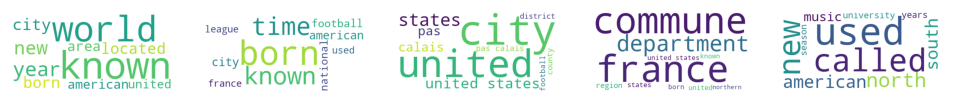

In [ ]:
fig = plt.figure(figsize=(10, 10), dpi=120)
for i in range(len(top_words)):
    ax = fig.add_subplot(1,5,i+1)
    wordcloud = WordCloud(background_color="white").generate_from_frequencies(top_words[i])

    ax.imshow(wordcloud)
    ax.axis('off')

Easy Topics

In [ ]:
#tf_vectorizer = CountVectorizer(stop_words='english')
tf_vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 2))
tf_easy = tf_vectorizer.fit_transform(X_easy)
tf_feature_names = tf_vectorizer.get_feature_names_out()
print(tf_easy.shape)

(19863, 173449)


In [ ]:
n_topics = 5

lda = LatentDirichletAllocation(n_components = n_topics, random_state=0)
lda.fit(tf_easy)
topic_models = lda.components_

In [ ]:
display_topics(lda, tf_feature_names, num_top_words)

topic 0: ['france', 'called', 'people', 'commune', 'department', 'city', 'region', 'used', 'new', 'north']
topic 1: ['commune', 'calais', 'pas calais', 'pas', 'france', 'known', 'north', 'football', 'called', 'born']
topic 2: ['born', 'player', 'football', 'football player', 'city', 'united', 'states', 'united states', 'american', 'used']
topic 3: ['united', 'states', 'united states', 'north', 'time', 'city', 'france', 'district', 'town', 'south']
topic 4: ['people', 'born', 'city', 'called', 'known', 'music', 'years', 'located', 'time', 'county']


In [ ]:
top_words = get_topics(lda, tf_feature_names, num_top_words)

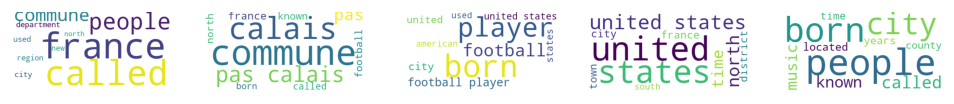

In [ ]:
fig = plt.figure(figsize=(10, 10), dpi=120)
for i in range(len(top_words)):
    ax = fig.add_subplot(1,5,i+1)
    wordcloud = WordCloud(background_color="white").generate_from_frequencies(top_words[i])

    ax.imshow(wordcloud)
    ax.axis('off')

# Dependencies

In [ ]:
#watermark with dependinces and versions
!pip install watermark
%load_ext watermark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.4 MB/s eta 0:00:00


In [ ]:
%watermark
%watermark --iversions

Last updated: 2023-02-26T18:14:52.641423+00:00

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.9.0

Compiler    : GCC 9.4.0
OS          : Linux
Release     : 5.10.147+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

numpy     : 1.22.4
matplotlib: 3.5.3
sklearn   : 1.0.2
pandas    : 1.3.5
re        : 2.2.1
altair    : 4.2.2

